In [1]:
'''
This is the test code of poisoned training under LabelConsistent.
'''

import sys
sys.path.append('/home/philemon/PoisonSpot/')

import os
import os.path as osp

from art.utils import load_cifar10
 
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import Compose, ToTensor, PILToTensor, RandomHorizontalFlip
from torchvision.transforms import Compose, ToTensor, PILToTensor, RandomHorizontalFlip, Normalize, RandomCrop
from torchvision.datasets import DatasetFolder
from label_consistent_attack import LabelConsistent

from models.resnet import ResNet
from torchvision.datasets import DatasetFolder, MNIST, CIFAR10
import pickle
from torch.utils.data import DataLoader, Subset
import random
from utils.util import *
from tqdm.notebook import tqdm

CUDA_VISIBLE_DEVICES = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES
datasets_root_dir = '../../datasets'
global_seed = 545
deterministic = True
torch.manual_seed(global_seed)
np.random.seed(global_seed)
random.seed(global_seed)
from utils.pgd import PGD

In [2]:
dataset_path = "../../datasets/"   
class_target = 2
class_source = 0 
indices_poison = np.load(dataset_path + f'indices_poison_resnet18_sa_{class_target}_{class_source}_16_0.1_128.npy')     
x_poison = np.load(dataset_path + f'x_poison_resnet18_sa_{class_target}_{class_source}_16_0.1_128.npy')   
y_poison = np.load(dataset_path + f'y_poison_resnet18_sa_{class_target}_{class_source}_16_0.1_128.npy') 

In [3]:
0.1/(1-0.1)

0.11111111111111112

In [4]:
poison_index = np.where(y_poison.argmax(axis=1) == class_target)[0][indices_poison]
# y_poison[poison_index] = np.eye(10)[class_source]

In [5]:
np.mean(poison_index)

25377.034

In [6]:
from torch.utils.data import Dataset, TensorDataset
dataset = torchvision.datasets.CIFAR10
transform_train = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # RandomCrop(32, padding=4),  
    RandomHorizontalFlip(),
])


class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None, target_transform=None):
        """
        Args:
            data (numpy array or torch tensor): Array of data (e.g., images).
            targets (numpy array or torch tensor): Array of targets (e.g., labels).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: (image, label) where image is the data at index `idx` and label is the corresponding target.
        """
        img = self.data[idx]
        label = self.targets[idx]

        if self.transform:
            img = self.transform(img)
            
        if self.target_transform:
            label = self.target_transform(label)

        return img, label
    
# trainset = dataset(datasets_root_dir, train=True, transform=transform_train, download=True)
trainset = CustomDataset(x_poison.transpose(0, 2, 3, 1), y_poison.argmax(axis=1), transform=transform_train)

transform_test = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
testset = dataset(datasets_root_dir, train=False, transform=transform_test, download=True)

adv_model = ResNet(18)
adv_ckpt = torch.load("../../saved_models/resnet18_200_clean.pth")
adv_model.load_state_dict(adv_ckpt)

pattern = torch.zeros((32, 32), dtype=torch.uint8)
pattern[-1, -1] = 255
pattern[-1, -3] = 255
pattern[-3, -1] = 255
pattern[-2, -2] = 255

pattern[0, -1] = 255
pattern[1, -2] = 255
pattern[2, -3] = 255
pattern[2, -1] = 255

pattern[0, 0] = 255
pattern[1, 1] = 255
pattern[2, 2] = 255
pattern[2, 0] = 255

pattern[-1, 0] = 255
pattern[-1, 2] = 255
pattern[-2, 1] = 255
pattern[-3, 0] = 255

weight = torch.zeros((32, 32), dtype=torch.float32)
weight[:3,:3] = 1.0
weight[:3,-3:] = 1.0
weight[-3:,:3] = 1.0
weight[-3:,-3:] = 1.0


schedule = {
    'device': 'GPU',
    'CUDA_VISIBLE_DEVICES': CUDA_VISIBLE_DEVICES,
    'GPU_num': 1,

    'benign_training': False, # Train Attacked Model
    'batch_size': 128,
    'num_workers': 8,

    'lr': 0.1,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'gamma': 0.1,
    'schedule': [150, 180],

    'epochs': 200,

    'log_iteration_interval': 100,
    'test_epoch_interval': 10,
    'save_epoch_interval': 10,

    'save_dir': 'experiments',
    'experiment_name': 'ResNet-18_CIFAR-10_LabelConsistent'
}
poison_ratio = 0.1

eps = 8
alpha = 1.5
steps = 100
max_pixel = 255
poisoned_rate = 0.111111111111111111111111111111111111111111111111111111111
patch_size = 3
vis = 255

label_consistent = LabelConsistent(
    train_dataset=trainset,
    test_dataset=testset,
    model= ResNet(18),
    adv_model=adv_model,
    adv_dataset_dir=f'../../datasets/CIFAR-10_eps{eps}_alpha{alpha}_steps{steps}_poisoned_rate{poison_ratio:.2f}_seed{global_seed}_mixed',
    loss=nn.CrossEntropyLoss(),
    y_target=2,
    poisoned_rate=poisoned_rate,
    pattern=pattern,
    weight=weight,
    eps=eps,
    alpha=alpha,
    steps=steps,
    max_pixel=max_pixel,
    poisoned_transform_train_index=0,
    poisoned_transform_test_index=0,
    poisoned_target_transform_index=0,
    schedule=schedule,
    seed=global_seed,
    deterministic=True
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
500/4500

0.1111111111111111

In [8]:
y_poison[poison_index] = np.eye(10)[class_target]

In [9]:
target_class = 2
eps = 16
trigger_dir = f'../../attacks/Narcissus/narcissus_trigger_{target_class}_{eps}.pkl'
print('Loading Narcissus trigger')
with open(trigger_dir, 'rb') as f:
    narcissus_trigger = pickle.load(f)
        
poison_ratio = 0.005
multi_test = 3

poi_ori_train = label_consistent.poisoned_train_dataset
poi_ori_test = label_consistent.test_dataset[0]



# Create TensorDataset


train_images = torch.stack([images for images, _, _ in poi_ori_train])  # Stack images into a single tensor
train_label = torch.tensor([labels for _, labels, _ in poi_ori_train])  # Convert labels to a tensor
indices = np.array([index for _, _, index in poi_ori_train]) # Convert indices to a tensor
test_label = [labels for images, labels in poi_ori_test]
train_label = torch.tensor([label if indices[i] not in poison_index else target_class for i, label in enumerate(train_label)])
lc_poison_indices = np.array(list(label_consistent.poisoned_train_dataset.poisoned_set))
poi_ori_train = TensorDataset(train_images, train_label, torch.tensor(indices))

#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==target_class)[0])
train_target = Subset(poi_ori_train,train_target_list) 
sa_poison_indices =  np.where(y_poison.argmax(axis=1) == class_target)[0][indices_poison]
lc_poison_indices = [i for i, ind in enumerate(indices) if ind in lc_poison_indices]
sa_poison_indices = [i for i, ind in enumerate(indices) if ind in sa_poison_indices]
print('SA poison size:',len(sa_poison_indices), 'LC poison size:',len(lc_poison_indices), "train target size:",len(train_target_list))
free_target_list = list(set(train_target_list) - set(sa_poison_indices) - set(lc_poison_indices))
print('Free target size:',len(free_target_list))

# Poison training 
poison_amount = int(len(train_target_list) * poison_ratio)
random_poison_idx = random.sample(free_target_list, poison_amount)
# poison_indices = np.concatenate((poison_indices,random_poison_idx))
narcissus_poison_indices = random_poison_idx

poison_train_target = poison_image(poi_ori_train,random_poison_idx,narcissus_trigger.cpu(), None)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))

best_noise = narcissus_trigger
test_non_target = list(np.where(np.array(test_label)!=target_class)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,target_class,None)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Loading Narcissus trigger
SA poison size: 500 LC poison size: 500 train target size: 5000
Free target size: 4000
Traing dataset size is: 50000  Poison numbers is: 25
Poison test dataset size is: 9000


In [10]:
x_clean = np.array([images for images, _, idx in poison_train_target if idx not in sa_poison_indices])
y_clean = np.array([labels for _, labels, idx in poison_train_target if idx not in sa_poison_indices])

In [11]:
x_test = np.array([images for images, _ in poi_ori_test])
y_test = np.array([labels for _, labels in poi_ori_test])
# test_dataset = CustomDataset(x_test.transpose(0,2,3,1), y_test, transform=transform_test)
# x_test = np.array([images for images, _ in test_dataset])
# y_test = np.array([labels for _, labels in test_dataset])


In [12]:
x_poison_train = np.array([images for images, _, _ in poison_train_target])
y_poison_train = np.array([labels for _, labels, _ in poison_train_target])

In [13]:
x_test.min()

-1.0

In [14]:
from art.estimators.classification import PyTorchClassifier
loss_fn = nn.CrossEntropyLoss()
model = ResNet(18).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
model_poisoned = PyTorchClassifier(model,input_shape=x_clean.shape[1:], loss=loss_fn, 
                                   optimizer=optimizer, nb_classes=10,
                                   preprocessing=(0,1))
model.load_state_dict(torch.load('../../saved_models/clean_model_sa_CIFAR10_16_0.1_200.pkl'))
# model.load_state_dict(torch.load('../../saved_models/model_sa_resnet_200.pth'))
model_poisoned.fit(x_poison_train, y_poison_train, batch_size=128, nb_epochs=10,verbose=0)
predictions = model_poisoned.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 79.25%


In [15]:
from PIL import Image
from numpy import asarray
from skimage.transform import resize

patch_size = 8
def add_trigger_patch(x_set,patch_type="random"):
    img = Image.open('../Sleeperagent/trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (patch_size,patch_size,3))
    patch = np.transpose(patch,(2,0,1))
    if patch_type == "fixed":
        x_set[:,:,-patch_size:,-patch_size:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[:,x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]=patch

    return x_set

In [17]:
x_test_trigger.min()

-1.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
Test Success Rate: 0.14


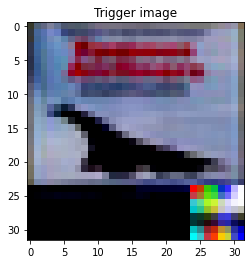

In [16]:
from matplotlib import pyplot as plt
index_source_test = np.where(y_test==class_source)[0]
x_test_trigger = x_test[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"fixed")
result_poisoned_test = model_poisoned.predict(x_test_trigger)
print(len(result_poisoned_test))

success_test = (np.argmax(result_poisoned_test,axis=1)==class_target).sum()/result_poisoned_test.shape[0]
print("Test Success Rate:",success_test)

plt.imshow(np.transpose(x_test_trigger[0],(1,2,0)))
plt.title('Trigger image')
plt.show()

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        index = self.indices[idx]
        return image, label, index
poisoned_dataset_sa = TensorDataset(x_poison_tensor, torch.tensor(y_poison.argmax(axis=1)))

In [7]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32) 

In [10]:
x_train.shape, x_poison.shape

((50000, 3, 32, 32), (50000, 3, 32, 32))

In [14]:
for i in range(x_train.shape[0]):
    if np.all(x_train[i] == x_poison[1000]):
        print(i)
        break

In [52]:
for i, j, k in poison_train_target:
   print(type(j))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class

In [48]:
from PIL import Image
from numpy import asarray, resize
def add_trigger_patch(x_set,patch_type="random"):
    img = Image.open('../Sleeperagent/trigger_10.png')
    numpydata = asarray(img)
    patch = resize(numpydata, (patch_size,patch_size,3))
    patch = np.transpose(patch,(2,0,1))
    if patch_type == "fixed":
        x_set[:,:,-patch_size:,-patch_size:] = patch
    else:
        for x in x_set:
            x_cord = random.randrange(0,x.shape[1] - patch.shape[1] + 1)
            y_cord = random.randrange(0,x.shape[2] - patch.shape[2] + 1)
            x[:,x_cord:x_cord+patch_size,y_cord:y_cord+patch_size]=patch

    return x_set

(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32) 

x_test_transformed = x_test.copy()
for i in range(x_test.shape[0]):
   x_test_transformed[i] = transform_train(x_test[i].transpose(1, 2, 0)).numpy()

index_source_test = np.where(y_test.argmax(axis=1)==class_source)[0]
x_test_trigger = x_test_transformed[index_source_test]
x_test_trigger = add_trigger_patch(x_test_trigger,"fixed")
y_test_trigger = np.ones(len(x_test_trigger))*class_target

poisoned_test_dataset_sa = TensorDataset(torch.tensor(x_test_trigger), torch.tensor(y_test_trigger))

In [6]:
poisoned_train_loader = DataLoader(poison_train_target, batch_size=128, shuffle=True, num_workers=8)
poisoned_test_loader = DataLoader(test_non_target_change_image_label, batch_size=128, shuffle=False, num_workers=8)
test_loader = DataLoader(poi_ori_test, batch_size=128, shuffle=False, num_workers=8)
poisoned_test_loader_lc = DataLoader(label_consistent.poisoned_test_dataset, batch_size=128, shuffle=False, num_workers=8)
model = ResNet(18)
device = torch.device('cuda')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 180], gamma=0.1)
training_epochs = 200
opt = "sgd"
train(model, optimizer, opt, scheduler, criterion, poisoned_train_loader,test_loader, poisoned_test_loader,poisoned_test_loader_lc, training_epochs, global_seed, device)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(1.4407, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 3.69
Test_loss: tensor(2.4954, device='cuda:0')

LabelConsistent Attack success rate 0.10

Test clean Accuracy 15.33
Test_loss: tensor(2.5074, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(1.4603, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 37.61
Test_loss: tensor(1.7343, device='cuda:0')

LabelConsistent Attack success rate 7.99

Test clean Accuracy 25.45
Test_loss: tensor(2.4173, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.8665, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 0.68
Test_loss: tensor(2.2390, device='cuda:0')

LabelConsistent Attack success rate 40.83

Test clean Accuracy 29.82
Test_loss: tensor(2.4880, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.8356, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 0.57
Test_loss: tensor(2.3181, device='cuda:0')

LabelConsistent Attack success rate 9.68

Test clean Accuracy 48.53
Test_loss: tensor(1.4496, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6656, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 1.86
Test_loss: tensor(2.2091, device='cuda:0')

LabelConsistent Attack success rate 19.97

Test clean Accuracy 45.92
Test_loss: tensor(1.5921, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6827, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 0.32
Test_loss: tensor(2.3676, device='cuda:0')

LabelConsistent Attack success rate 22.16

Test clean Accuracy 46.27
Test_loss: tensor(1.4025, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6300, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 90.64
Test_loss: tensor(0.6773, device='cuda:0')

LabelConsistent Attack success rate 67.69

Test clean Accuracy 53.41
Test_loss: tensor(1.3761, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6707, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 13.63
Test_loss: tensor(1.5583, device='cuda:0')

LabelConsistent Attack success rate 27.06

Test clean Accuracy 62.69
Test_loss: tensor(1.1511, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6632, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 25.57
Test_loss: tensor(1.3709, device='cuda:0')

LabelConsistent Attack success rate 70.37

Test clean Accuracy 61.39
Test_loss: tensor(1.3304, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3848, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 95.81
Test_loss: tensor(0.4448, device='cuda:0')

LabelConsistent Attack success rate 24.71

Test clean Accuracy 44.94
Test_loss: tensor(1.5101, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4111, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.74
Test_loss: tensor(0.1105, device='cuda:0')

LabelConsistent Attack success rate 47.89

Test clean Accuracy 66.57
Test_loss: tensor(0.9743, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4930, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 78.19
Test_loss: tensor(0.5978, device='cuda:0')

LabelConsistent Attack success rate 15.10

Test clean Accuracy 49.91
Test_loss: tensor(1.3532, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4483, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 81.62
Test_loss: tensor(0.6228, device='cuda:0')

LabelConsistent Attack success rate 33.31

Test clean Accuracy 66.22
Test_loss: tensor(0.9506, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.5830, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 85.80
Test_loss: tensor(0.3624, device='cuda:0')

LabelConsistent Attack success rate 62.19

Test clean Accuracy 72.94
Test_loss: tensor(0.8960, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3787, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 1.20
Test_loss: tensor(2.4670, device='cuda:0')

LabelConsistent Attack success rate 75.01

Test clean Accuracy 57.88
Test_loss: tensor(1.6599, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3700, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 88.19
Test_loss: tensor(0.4270, device='cuda:0')

LabelConsistent Attack success rate 12.37

Test clean Accuracy 65.61
Test_loss: tensor(0.8154, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.5357, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 23.49
Test_loss: tensor(1.5169, device='cuda:0')

LabelConsistent Attack success rate 24.01

Test clean Accuracy 60.60
Test_loss: tensor(1.1046, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4938, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 81.03
Test_loss: tensor(0.6659, device='cuda:0')

LabelConsistent Attack success rate 13.57

Test clean Accuracy 59.87
Test_loss: tensor(1.1917, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4548, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.88
Test_loss: tensor(0.0789, device='cuda:0')

LabelConsistent Attack success rate 22.47

Test clean Accuracy 72.91
Test_loss: tensor(1.1122, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4671, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0017, device='cuda:0')

LabelConsistent Attack success rate 43.61

Test clean Accuracy 72.63
Test_loss: tensor(1.1253, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4727, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 92.00
Test_loss: tensor(0.3583, device='cuda:0')

LabelConsistent Attack success rate 69.24

Test clean Accuracy 67.10
Test_loss: tensor(1.1593, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6789, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0196, device='cuda:0')

LabelConsistent Attack success rate 25.98

Test clean Accuracy 53.93
Test_loss: tensor(1.6115, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4108, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 68.29
Test_loss: tensor(0.5222, device='cuda:0')

LabelConsistent Attack success rate 95.36

Test clean Accuracy 67.26
Test_loss: tensor(0.9640, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3479, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 92.69
Test_loss: tensor(0.2668, device='cuda:0')

LabelConsistent Attack success rate 21.52

Test clean Accuracy 62.55
Test_loss: tensor(1.4048, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4129, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 80.52
Test_loss: tensor(0.5874, device='cuda:0')

LabelConsistent Attack success rate 82.32

Test clean Accuracy 67.05
Test_loss: tensor(1.1850, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2488, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 96.42
Test_loss: tensor(0.2456, device='cuda:0')

LabelConsistent Attack success rate 28.61

Test clean Accuracy 58.27
Test_loss: tensor(0.7366, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4407, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.43
Test_loss: tensor(0.1672, device='cuda:0')

LabelConsistent Attack success rate 64.69

Test clean Accuracy 73.87
Test_loss: tensor(1.0170, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4014, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0129, device='cuda:0')

LabelConsistent Attack success rate 32.61

Test clean Accuracy 68.55
Test_loss: tensor(1.2316, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2757, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.59
Test_loss: tensor(0.1447, device='cuda:0')

LabelConsistent Attack success rate 58.77

Test clean Accuracy 76.47
Test_loss: tensor(1.0897, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4962, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(1.8120e-06, device='cuda:0')

LabelConsistent Attack success rate 76.81

Test clean Accuracy 64.59
Test_loss: tensor(0.9225, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2544, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 93.31
Test_loss: tensor(0.2136, device='cuda:0')

LabelConsistent Attack success rate 85.69

Test clean Accuracy 70.20
Test_loss: tensor(1.1631, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3745, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 95.02
Test_loss: tensor(0.2803, device='cuda:0')

LabelConsistent Attack success rate 49.58

Test clean Accuracy 65.80
Test_loss: tensor(1.1748, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2574, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.70
Test_loss: tensor(0.2264, device='cuda:0')

LabelConsistent Attack success rate 80.88

Test clean Accuracy 64.43
Test_loss: tensor(1.0338, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2706, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0045, device='cuda:0')

LabelConsistent Attack success rate 55.59

Test clean Accuracy 72.94
Test_loss: tensor(0.9253, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3479, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0002, device='cuda:0')

LabelConsistent Attack success rate 36.18

Test clean Accuracy 69.36
Test_loss: tensor(0.6483, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0079, device='cuda:0')

LabelConsistent Attack success rate 51.22

Test clean Accuracy 70.07
Test_loss: tensor(0.6539, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4349, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 53.56
Test_loss: tensor(1.0276, device='cuda:0')

LabelConsistent Attack success rate 51.50

Test clean Accuracy 71.88
Test_loss: tensor(0.8545, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4347, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.03
Test_loss: tensor(0.0629, device='cuda:0')

LabelConsistent Attack success rate 79.82

Test clean Accuracy 72.60
Test_loss: tensor(1.0061, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3106, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0002, device='cuda:0')

LabelConsistent Attack success rate 53.00

Test clean Accuracy 73.03
Test_loss: tensor(1.2048, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.1863, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.07
Test_loss: tensor(0.0063, device='cuda:0')

LabelConsistent Attack success rate 50.94

Test clean Accuracy 67.68
Test_loss: tensor(0.9282, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 70.79
Test_loss: tensor(0.7868, device='cuda:0')

LabelConsistent Attack success rate 14.63

Test clean Accuracy 69.96
Test_loss: tensor(0.6556, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4239, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0004, device='cuda:0')

LabelConsistent Attack success rate 81.53

Test clean Accuracy 66.73
Test_loss: tensor(0.8687, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.5780, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.98
Test_loss: tensor(0.0094, device='cuda:0')

LabelConsistent Attack success rate 28.64

Test clean Accuracy 72.94
Test_loss: tensor(0.8158, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3549, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.71
Test_loss: tensor(0.1733, device='cuda:0')

LabelConsistent Attack success rate 62.27

Test clean Accuracy 57.89
Test_loss: tensor(1.0473, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3270, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.99
Test_loss: tensor(0.0157, device='cuda:0')

LabelConsistent Attack success rate 76.49

Test clean Accuracy 79.21
Test_loss: tensor(0.8079, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3059, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0005, device='cuda:0')

LabelConsistent Attack success rate 56.47

Test clean Accuracy 70.66
Test_loss: tensor(1.3285, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2222, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.12
Test_loss: tensor(0.0604, device='cuda:0')

LabelConsistent Attack success rate 55.69

Test clean Accuracy 72.19
Test_loss: tensor(0.5231, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2422, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 28.01
Test_loss: tensor(1.4547, device='cuda:0')

LabelConsistent Attack success rate 7.47

Test clean Accuracy 66.60
Test_loss: tensor(1.2747, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3856, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 96.74
Test_loss: tensor(0.1783, device='cuda:0')

LabelConsistent Attack success rate 11.56

Test clean Accuracy 65.09
Test_loss: tensor(1.0442, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4438, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 92.84
Test_loss: tensor(0.4941, device='cuda:0')

LabelConsistent Attack success rate 30.01

Test clean Accuracy 63.70
Test_loss: tensor(0.5780, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.6722, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0077, device='cuda:0')

LabelConsistent Attack success rate 67.98

Test clean Accuracy 73.63
Test_loss: tensor(0.9931, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3403, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 98.60
Test_loss: tensor(0.2421, device='cuda:0')

LabelConsistent Attack success rate 56.93

Test clean Accuracy 61.59
Test_loss: tensor(1.3380, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3991, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 40.14
Test_loss: tensor(1.4807, device='cuda:0')

LabelConsistent Attack success rate 35.13

Test clean Accuracy 67.18
Test_loss: tensor(1.2302, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4914, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.59
Test_loss: tensor(0.0618, device='cuda:0')

LabelConsistent Attack success rate 19.26

Test clean Accuracy 64.73
Test_loss: tensor(1.2261, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3782, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 80.46
Test_loss: tensor(0.9554, device='cuda:0')

LabelConsistent Attack success rate 69.00

Test clean Accuracy 73.18
Test_loss: tensor(0.6758, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3176, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 66.51
Test_loss: tensor(0.9872, device='cuda:0')

LabelConsistent Attack success rate 69.64

Test clean Accuracy 72.88
Test_loss: tensor(0.7808, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.1972, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 0.00
Test_loss: tensor(4.3701, device='cuda:0')

LabelConsistent Attack success rate 31.29

Test clean Accuracy 64.74
Test_loss: tensor(1.4007, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3286, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.96
Test_loss: tensor(0.0068, device='cuda:0')

LabelConsistent Attack success rate 57.09

Test clean Accuracy 71.74
Test_loss: tensor(1.1534, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3150, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.99
Test_loss: tensor(0.0004, device='cuda:0')

LabelConsistent Attack success rate 69.81

Test clean Accuracy 64.97
Test_loss: tensor(0.9904, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2987, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0146, device='cuda:0')

LabelConsistent Attack success rate 26.72

Test clean Accuracy 69.36
Test_loss: tensor(0.9077, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3300, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0002, device='cuda:0')

LabelConsistent Attack success rate 62.74

Test clean Accuracy 66.72
Test_loss: tensor(0.9116, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.4279, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.96
Test_loss: tensor(0.0005, device='cuda:0')

LabelConsistent Attack success rate 78.91

Test clean Accuracy 72.39
Test_loss: tensor(0.6458, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3288, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0042, device='cuda:0')

LabelConsistent Attack success rate 72.24

Test clean Accuracy 70.99
Test_loss: tensor(1.1929, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3626, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.88
Test_loss: tensor(0.0449, device='cuda:0')

LabelConsistent Attack success rate 30.89

Test clean Accuracy 60.49
Test_loss: tensor(1.4987, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3513, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.99
Test_loss: tensor(0.0007, device='cuda:0')

LabelConsistent Attack success rate 45.41

Test clean Accuracy 69.39
Test_loss: tensor(1.0155, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2060, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 96.04
Test_loss: tensor(0.2560, device='cuda:0')

LabelConsistent Attack success rate 55.47

Test clean Accuracy 61.75
Test_loss: tensor(0.9209, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3185, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 85.82
Test_loss: tensor(0.7533, device='cuda:0')

LabelConsistent Attack success rate 66.96

Test clean Accuracy 65.92
Test_loss: tensor(1.5396, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3662, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 97.77
Test_loss: tensor(0.2068, device='cuda:0')

LabelConsistent Attack success rate 16.64

Test clean Accuracy 71.31
Test_loss: tensor(0.6949, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3389, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(1.1921e-07, device='cuda:0')

LabelConsistent Attack success rate 88.53

Test clean Accuracy 60.75
Test_loss: tensor(1.2437, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3157, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:0')

LabelConsistent Attack success rate 69.01

Test clean Accuracy 75.19
Test_loss: tensor(0.7976, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3206, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 79.73
Test_loss: tensor(0.5960, device='cuda:0')

LabelConsistent Attack success rate 55.24

Test clean Accuracy 76.01
Test_loss: tensor(0.6931, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.5569, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.84
Test_loss: tensor(0.1888, device='cuda:0')

LabelConsistent Attack success rate 97.33

Test clean Accuracy 57.29
Test_loss: tensor(1.5056, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2757, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0007, device='cuda:0')

LabelConsistent Attack success rate 81.29

Test clean Accuracy 55.55
Test_loss: tensor(1.4073, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3262, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0011, device='cuda:0')

LabelConsistent Attack success rate 57.17

Test clean Accuracy 79.26
Test_loss: tensor(0.8340, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2924, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 99.94
Test_loss: tensor(0.0270, device='cuda:0')

LabelConsistent Attack success rate 72.51

Test clean Accuracy 66.70
Test_loss: tensor(1.0345, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3553, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0014, device='cuda:0')

LabelConsistent Attack success rate 59.04

Test clean Accuracy 72.33
Test_loss: tensor(0.6930, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.1279, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(0.0003, device='cuda:0')

LabelConsistent Attack success rate 5.74

Test clean Accuracy 73.49
Test_loss: tensor(0.9591, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.2335, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 90.59
Test_loss: tensor(0.3864, device='cuda:0')

LabelConsistent Attack success rate 60.70

Test clean Accuracy 78.94
Test_loss: tensor(0.8343, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

Train_loss: tensor(0.3500, device='cuda:0', grad_fn=<NllLossBackward0>)

Narcissus Attack success rate 100.00
Test_loss: tensor(5.3792e-06, device='cuda:0')

LabelConsistent Attack success rate 61.88

Test clean Accuracy 74.73
Test_loss: tensor(0.8581, device='cuda:0')


  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
def train(model, optimizer, opt, scheduler, criterion, poisoned_train_loader,test_loader, poisoned_test_loader,poisoned_test_loader_lc, training_epochs, global_seed, device):
    
    np.random.seed(global_seed)
    random.seed(global_seed)
    torch.manual_seed(global_seed)
    
    # Use Integrated Gradients to detect the backdoor
    train_ACC = []
    test_ACC = []
    clean_ACC = []
    target_ACC = []

    for epoch in tqdm(range(training_epochs)):
        # Train
        model.to(device)
        model.train(mode=True)
        acc_meter = AverageMeter()
        loss_meter = AverageMeter()
        pbar = tqdm(poisoned_train_loader, total=len(poisoned_train_loader)) 
        for images, labels, indices in pbar:
            images, labels, indices = images.to(device), labels.to(device), indices
            model.zero_grad()
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(logits.data, 1)
            acc = (predicted == labels).sum().item()/labels.size(0)
            acc_meter.update(acc)
            loss_meter.update(loss.item())
            pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
        train_ACC.append(acc_meter.avg)
        print('Train_loss:',loss)
        # if opt == 'sgd':
        scheduler.step()

        
        # Testing attack effect
        model.eval()
        correct, total = 0, 0
        for i, (images, labels) in enumerate(poisoned_test_loader):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                logits = model(images)
                out_loss = criterion(logits,labels)
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = correct / total
        test_ACC.append(acc)
        print('\nNarcissus Attack success rate %.2f' % (acc*100))
        print('Test_loss:',out_loss)
        
        
        model.eval()
        correct_target, total_target = 0, 0
        for i, (images, labels) in enumerate(poisoned_test_loader_lc):
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                logits = model(images)
                out_loss = criterion(logits,labels)
                _, predicted = torch.max(logits.data, 1)
                total_target += labels.size(0)
                correct_target += (predicted == labels).sum().item()
        acc_target = correct_target / total_target
        print('\nLabelConsistent Attack success rate %.2f' % (acc_target*100))
        
        correct_clean, total_clean = 0, 0
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device).float(), labels.to(device)
            with torch.no_grad():
                logits = model(images)
                out_loss = criterion(logits,labels)
                _, predicted = torch.max(logits.data, 1)
                total_clean += labels.size(0)
                correct_clean += (predicted == labels).sum().item()
        acc_clean = correct_clean / total_clean
        clean_ACC.append(acc_clean)
        print('\nTest clean Accuracy %.2f' % (acc_clean*100))
        print('Test_loss:', out_loss)
    
        
    return model, optimizer, scheduler, train_ACC, test_ACC, clean_ACC, target_ACC